# Plot for paper

In [1]:
import numpy as np
from matsindy.feature_library import FeatureLibrary

from ipywidgets import interactive, fixed
import ipywidgets as widgets
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.pyplot import cm
from matplotlib.ticker import FormatStrFormatter


plt.rcParams.update({
    "text.usetex": True,
    "font.size": 14,
    "font.family": "serif",
    "font.serif": "newcent",
    "text.latex.preamble": "\\usepackage[T1]{fontenc}\n\\usepackage{fourier}",
    
})

## Datasets selection

In [2]:
Wi_max = 1000                       # Peak Weissenberg number in simulations
n_links = 1000                      # Number of segments in the Kramers chain
n_ensemble = 1000                     # Number of molecules to simulate

# Input folder
data_folder = 'outputs/Kramers'
                    
# Name: file
scenarios = [
    'turbulence_2',
    'inkjet_0',
    'contraction_0',
    'elongation_0_noBF',
    'sonication_0',
    'elongation_0_noBF_DP1.01',
    'contraction_0_PD',
    'sonication_0_PD',
]

# Load data with rescaling
dataset = {}
for scenario in scenarios:
    with np.load(f"{data_folder}/{scenario}_Wi{Wi_max}_nlinks{n_links}_nmol{n_ensemble}.npz") as data:
        temp = dict(data)
        # Rename and normalise variables
        tau = 0.0142*n_links**2
        temp['A'] = temp.pop('A_average')/n_links**2
        temp['∇U'] = temp.pop('gradU')*tau
        temp['t'] = temp['t']/tau
        # Add transposed variables
        temp['∇Uᵀ'] = np.transpose(temp['∇U'], axes=(0, 2, 1))
        # Add features
        temp['tr(A)'] = np.trace(temp['A'], axis1=1, axis2=2)
        temp['tr(A∇U)'] = np.trace(temp['A']@temp['∇U'], axis1=1, axis2=2)     
        
        # Flow properties
        temp['epsilon_dot'] = np.linalg.eigvalsh(0.5*(temp['∇U'] + temp['∇Uᵀ']))
        
        # Effective principal strain rate
        temp['epsilon_dot_eff'] = temp['tr(A∇U)']/temp['tr(A)']
        
        # Estimates of the Henky strain, one using principal strain rates, the other using polymer extension
        epsilon = np.zeros_like(temp['t'])
        # Buckling strain
        phi = np.zeros_like(temp['t'])
        # Effective positive strain
        epsilon_eff = np.zeros_like(temp['t'])
        for i, dt in enumerate(np.diff(temp['t'])):
            epsilon[i+1] = np.amax(temp['epsilon_dot'][i])*dt + epsilon[i]
            
            # Buckling strain rate
            if temp['epsilon_dot_eff'][i] < 0 or phi[i] < -1e-6:
                epsilon_dot_b = temp['epsilon_dot_eff'][i]
            else:
                epsilon_dot_b = 0.
            phi[i+1] = (epsilon_dot_b + phi[i]/dt)/(1./dt + 1.)
            
            epsilon_eff[i+1] = (temp['epsilon_dot_eff'][i] - epsilon_dot_b + epsilon_eff[i]/dt)/(1./dt + 1.)
        temp['epsilon'] = epsilon
        temp['phi'] = phi
        temp['epsilon_eff'] = epsilon_eff
        
        # Effective square segment
        g_maxf = temp['g_max'].copy()
        g_maxf[g_maxf<4] = 0
        temp['L2'] = g_maxf/temp['epsilon_dot'][:,2]*0.0142*8
        g_12f = temp['g_12'].copy()
        g_12f[g_12f<4] = 0
        temp['M2'] = g_12f/temp['epsilon_dot'][:,2]*0.0142*8
        g_13f = temp['g_13'].copy()
        g_13f[g_13f<4] = 0
        temp['M13'] = g_13f/temp['epsilon_dot'][:,2]*0.0142*8


        # Save
        dataset[scenario] = temp

/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in true_divide
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in true_divide
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in true_divide
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide


## Plot flow characteristics

/home/etienne/miniconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/etienne/miniconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/etienne/miniconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


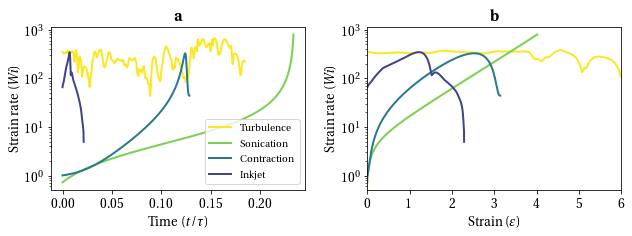

In [3]:
cols = ['#fde725', '#7ad151', '#22a884', '#2a788e', '#414487', '#440154']

sonication_ls = {'color': '#7ad151',
                'linewidth': 2,
                'linestyle': 'solid'}

contraction_ls = {'color': '#2a788e',
                'linewidth': 2,
                'linestyle': 'solid'}

inkjet_ls = {'color': '#414487',
                'linewidth': 2,
                'linestyle': 'solid'}

turbulence_ls = {'color': '#fde725',
                'linewidth': 2,
                'linestyle': 'solid'}

elongation_noBF_ls = {'color': 'k',
                'linewidth': 1,
                'linestyle': ':'}


plt.rcParams['figure.figsize'] = [9, 3.5]
fig, ax = plt.subplots(ncols=2)


ax[0].semilogy(dataset['turbulence_2']['t'], dataset['turbulence_2']['epsilon_dot'][:,2], **turbulence_ls, label='Turbulence')
ax[0].semilogy(dataset['sonication_0']['t'][:-141], dataset['sonication_0']['epsilon_dot'][:-141,2], **sonication_ls, label='Sonication')
ax[0].semilogy(dataset['contraction_0']['t'][:-90], dataset['contraction_0']['epsilon_dot'][:-90,2], **contraction_ls, label='Contraction')
ax[0].semilogy(dataset['inkjet_0']['t'], dataset['inkjet_0']['epsilon_dot'][:,2], **inkjet_ls, label='Inkjet')
ax[0].set_xlabel(r'Time ($t/\tau$)')
#ax[0,0].set_xlim(0,6)
ax[0].set_ylabel(r'Strain rate (\textit{Wi})')
ax[0].legend(fontsize=11, loc='lower right')
ax[0].set_title(r'\textbf a')


#ax[1].plot(dataset['inkjet_0']['t'], dataset['inkjet_0']['epsilon'], **inkjet_ls)
#ax[1].plot(dataset['sonication_0']['t'][:-141], dataset['sonication_0']['epsilon'][:-141], **sonication_ls, label='Sonication')
#ax[1].plot(dataset['contraction_0']['t'][:-90], dataset['contraction_0']['epsilon'][:-90], **contraction_ls, label='Contraction')
#ax[1].set_xlabel('Time ($t/\\tau$)')
#ax[1].set_ylabel('Strain ($\\varepsilon$)')
#ax[1].set_yticks(ticks=[0, 1, 2, 3, 4])
#ax[1].set_title('\\textbf b')


ax[1].semilogy(dataset['turbulence_2']['epsilon'], dataset['turbulence_2']['epsilon_dot'][:,2], **turbulence_ls)
ax[1].semilogy(dataset['sonication_0']['epsilon'][:-141], dataset['sonication_0']['epsilon_dot'][:-141,2], **sonication_ls, label='Sonication')
ax[1].semilogy(dataset['contraction_0']['epsilon'][:-90], dataset['contraction_0']['epsilon_dot'][:-90,2], **contraction_ls, label='Contraction')
ax[1].semilogy(dataset['inkjet_0']['epsilon'], dataset['inkjet_0']['epsilon_dot'][:,2], **inkjet_ls)
ax[1].set_xlabel(r'Strain ($\varepsilon$)')
ax[1].set_xticks(ticks=[0, 1, 2, 3, 4, 5, 6])
ax[1].set_xlim(0,6)
ax[1].set_ylabel(r'Strain rate (\textit{Wi})')
ax[1].set_title(r'\textbf b')




plt.tight_layout()
plt.savefig('plot_scenarios.pdf') 

## Plot polymers detail

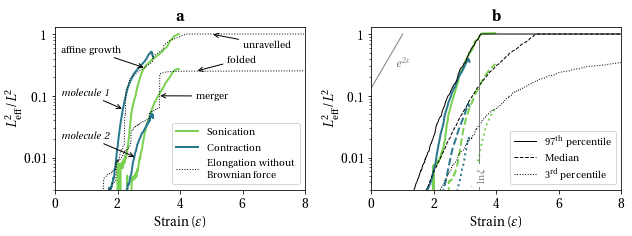

In [11]:
plt.rcParams['figure.figsize'] = [9, 3.5]
fig, ax = plt.subplots(ncols=2)

#ax[0].semilogy(dataset['inkjet_0']['epsilon'], dataset['inkjet_0']['tr(A)'], **inkjet_ls, label='Inkjet')
#ax[0].semilogy(dataset['sonication_0']['epsilon'], dataset['sonication_0']['tr(A)'], **sonication_ls, label='Sonication')
#ax[0].semilogy(dataset['contraction_0']['epsilon'], dataset['contraction_0']['tr(A)'], **contraction_ls, label='Contraction')
#ax[0].semilogy(dataset['turbulence_2']['epsilon'], dataset['turbulence_2']['tr(A)'], **contraction_ls, label='Turbulence')
#ax[0].semilogy(dataset['elongation_0_noBF']['epsilon'], dataset['elongation_0_noBF']['tr(A)'], **elongation_noBF_ls, label='Elongation without\nBrownian force')
#ax[0].set_xlabel('Strain ($\\varepsilon$)')
#ax[0].set_ylabel('$\langle R_{EE}^2\\rangle/L^2$', labelpad=0)
#ax[0].set_xlim(0,8)
#ax[0].legend(fontsize=11)
#ax[0].set_title('\\textbf a')
#x = np.linspace(0, 4)
#ax[0,0].semilogy(x, np.exp(2*(x-np.log(n_links)/12)-np.log(n_links)))
#ax[0,0].semilogy(x, np.exp(2*x-np.log(n_links)))
#ax[0,0].semilogy([np.log(n_links)/2, 7*np.log(n_links)/12], [1, 1])

ax[0].semilogy(dataset['sonication_0']['epsilon'][:-142], dataset['sonication_0']['L2'][3,:-142], color='#7ad151', linewidth=2, label='Sonication')
ax[0].semilogy(dataset['contraction_0']['epsilon'][:-90], dataset['contraction_0']['L2'][3,:-90], color='#2a788e', linewidth=2, label='Contraction')
#ax[1].semilogy(dataset['turbulence_2']['epsilon'], dataset['turbulence_2']['L2'][3], color='#414487', linewidth=2, label='Contraction')
ax[0].semilogy(dataset['elongation_0_noBF']['epsilon'], dataset['elongation_0_noBF']['L2'][3], ls=':', color='k', linewidth=1, label='Elongation without\nBrownian force')    
# other examples
for i in [2]:
    ax[0].semilogy(dataset['sonication_0']['epsilon'][:-142], dataset['sonication_0']['L2'][i,:-142], color='#7ad151', linewidth=2)
    ax[0].semilogy(dataset['contraction_0']['epsilon'][:-90], dataset['contraction_0']['L2'][i,:-90], color='#2a788e', linewidth=2)
    ax[0].semilogy(dataset['elongation_0_noBF']['epsilon'], dataset['elongation_0_noBF']['L2'][i], ls=':', color='k', linewidth=1)    
# Labels
ax[0].annotate('unravelled', xy=(5, 1), xytext=(6, 0.6), arrowprops=dict(arrowstyle="->"), fontsize=11)
ax[0].annotate('folded', xy=(4.5, 0.25), xytext=(5.5, 0.35), arrowprops=dict(arrowstyle="->"), fontsize=11)
ax[0].annotate('merger', xy=(3.3, 0.1), xytext=(4.5, 0.09), arrowprops=dict(arrowstyle="->"), fontsize=11)
ax[0].annotate('affine growth', xy=(2.9, 0.28), xytext=(0.2, 0.5), arrowprops=dict(arrowstyle="->"), fontsize=11)
ax[0].annotate(r'\textit{molecule 1}', xy=(2.2, 0.06), xytext=(0.2, 0.1), arrowprops=dict(arrowstyle="->"), fontsize=11)
ax[0].annotate(r'\textit{molecule 2}', xy=(2.6, 0.01), xytext=(0.2, 0.02), arrowprops=dict(arrowstyle="->"), fontsize=11)

ax[0].set_xlabel(r'Strain ($\varepsilon$)')
ax[0].set_xlim(0,8)
ax[0].set_ylabel(r'$L_\mathrm{eff}^2/L^2$', labelpad=0)
ax[0].set_ylim(0.003,1.3)
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax[0].legend(fontsize=11)

ax[0].set_title(r'\textbf a')


ax[1].semilogy(dataset['sonication_0']['epsilon'][:-142], np.percentile(dataset['sonication_0']['L2'][:,:-142], 97, axis=0), color='#7ad151', ls='-',linewidth=2)
ax[1].semilogy(dataset['sonication_0']['epsilon'][:-142], np.percentile(dataset['sonication_0']['L2'][:,:-142], 50, axis=0), color='#7ad151', ls='--',linewidth=2)
ax[1].semilogy(dataset['sonication_0']['epsilon'][:-142], np.percentile(dataset['sonication_0']['L2'][:,:-142], 3, axis=0), color='#7ad151', ls=':',linewidth=2)
ax[1].semilogy(dataset['contraction_0']['epsilon'][:-90], np.percentile(dataset['contraction_0']['L2'][:,:-90], 97, axis=0), color='#2a788e', ls='-',linewidth=2)
ax[1].semilogy(dataset['contraction_0']['epsilon'][:-90], np.percentile(dataset['contraction_0']['L2'][:,:-90], 50, axis=0), color='#2a788e', ls='--',linewidth=2)
ax[1].semilogy(dataset['contraction_0']['epsilon'][:-90], np.percentile(dataset['contraction_0']['L2'][:,:-90], 3, axis=0), color='#2a788e', ls=':',linewidth=2)

ax[1].semilogy(dataset['elongation_0_noBF']['epsilon'], np.percentile(dataset['elongation_0_noBF']['L2'], 97, axis=0), color='k', ls='-',linewidth=1, label=r'$97^\mathrm{th}$ percentile')
ax[1].semilogy(dataset['elongation_0_noBF']['epsilon'], np.percentile(dataset['elongation_0_noBF']['L2'], 50, axis=0), color='k', ls='--',linewidth=1, label=r'Median')
ax[1].semilogy(dataset['elongation_0_noBF']['epsilon'], np.percentile(dataset['elongation_0_noBF']['L2'], 3, axis=0), color='k', ls=':',linewidth=1, label=r'$3^\mathrm{rd}$ percentile')
ax[1].semilogy(np.linspace(0,1), np.exp(2*np.linspace(0,1)-2), color='grey', ls='-',linewidth=1) 
ax[1].text(0.8, 0.3, r'$e^{2\varepsilon}$', color='grey', fontsize=12)
ax[1].text(np.log(n_links)/2-0.1, 0.005, r'$\ln \xi$', bbox={'fc': '1', 'ec': 'None'}, rotation=90, fontsize=11, color='grey')
ax[1].axvline(np.log(n_links)/2, 0, 0.92, ls='-', color='grey', linewidth=1)
ax[1].set_xlabel(r'Strain ($\varepsilon$)')
ax[1].set_xlim(0,8)
ax[1].legend(fontsize=11)
ax[1].set_ylabel(r'$L_\mathrm{eff}^2/L^2$', labelpad=0)
ax[1].set_ylim(0.003,1.3)
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax[1].set_title(r'\textbf b')



plt.tight_layout()
plt.savefig('plot_molecules.pdf') 

***

## Simulate scission

For an elongated chain, the maximum tension is at the centre and given by:
$$
g_\max = Wi\left(\frac{N^2}{8} + \frac{N}{2} \right)
$$
So a critical tension corresponds to a critical Weissenberg number
$$
Wi_c = \frac{g_c}{\frac{N^2}{8} + \frac{N}{2}}
$$
with usually $N \gg 1$ we keep the $N^2$ term only.

### Monodispersed

In [12]:
data = dataset['elongation_0_noBF']

Wi_c = 100
threshold = Wi_c/(8*0.0142)

cs_mono = []

# Tensions are going to be rescaled with Wi
Wis = np.logspace(np.log10(Wi_c)-1,np.log10(Wi_c)+2,100)

for Wi in Wis:

    events = np.zeros_like(data['t'])
    for tension_max in Wi*data['L2']/(0.0142*8):
        for i, g_max in enumerate(tension_max):
            
            if g_max > threshold:
                # Non-specific scission
                events[i] += 1
                break
                
    c = 1. - np.cumsum(events)/n_ensemble
    cs_mono.append(c)

cs_mono = np.array(cs_mono)

### Polydispersed

In [13]:
## With PD = 1.01

data = dataset['elongation_0_noBF_DP1.01']

cs_poly = []

for Wi in Wis:

    events = np.zeros_like(data['t'])
    for tension_max in Wi*data['L2']/(0.0142*8):
        for i, g_max in enumerate(tension_max):
            
            if g_max > threshold:
                # Non-specific scission
                events[i] += 1
                break
                
    c = 1. - np.cumsum(events)/n_ensemble
    cs_poly.append(c)

cs_poly = np.array(cs_poly)

### Model fit

In [14]:
def build_model(params):
    c_model = np.ones_like(cs_poly)
    
    for i, w in enumerate(Wis/Wi_c):
        kappa = params[0] + params[1]*np.log(w)**2
        f = 1./(1 + np.exp(-np.log(w)/params[2]))
        g = params[3]*np.log((1 + np.exp((dataset['elongation_0_noBF_DP1.01']['epsilon'] - np.log(n_links)/2 + params[4]*np.log(w))/params[3])))
        
        c_model[i] = np.exp(-kappa*f*g)
        
    return c_model


def loss(params):
    return np.sum((cs_poly-build_model(params))**2)


from scipy.optimize import minimize
                                    
res = minimize(loss, [0.4, 0.01, 0.2, 0.2, 0.25])

print(res.message)
pms = np.sqrt(np.diag(res.hess_inv))
params = ['kappa_0', 'kappa_1', 'gamma_0', 'gamma_1', 'beta_0']
for param, value, pm in zip(params, res.x, pms):
    print(f"{param} = {value:.3f} ± {pm:.3f}")

c_model = build_model(res.x)

Desired error not necessarily achieved due to precision loss.
kappa_0 = 0.360 ± 0.010
kappa_1 = 0.362 ± 0.021
gamma_0 = 0.080 ± 0.005
gamma_1 = 0.195 ± 0.014
beta_0 = 0.234 ± 0.010


Inspect the result:

/home/etienne/miniconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


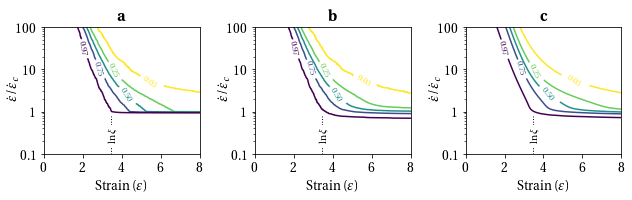

In [15]:
plt.rcParams['figure.figsize'] = [9, 3]
fig, ax = plt.subplots(ncols=3)

levels = [0.03, 0.25, 0.5, 0.75, 0.97]
label_pos = [(5,3),
             (4,10),
             (3.8,2),
             (2.8,10),
             (2,30)
            ]
#ccols = ['#dde318', '#5ec962', '#21918c', '#3b528b', '#440154']

CS = ax[0].contour(data['epsilon'], Wis/Wi_c, cs_mono, levels, cmap='viridis_r') # viridis_r, YlGnBu
ax[0].set_yscale('log')
for level, position in zip(levels, label_pos):
    ax[0].clabel(CS, [level], inline=True, fontsize=9, fmt='%1.2f', manual=[position])
ax[0].set_xlabel('Strain ($\\varepsilon$)')
ax[0].set_ylabel('$\\dot\\varepsilon/\\dot\\varepsilon_c$', labelpad=-5)
ax[0].text(np.log(n_links)/2-0.2, 0.25, '$\\ln \\xi$', bbox={'fc': '1', 'ec': 'None'}, rotation=90, fontsize=11)
ax[0].set_ylim(0.1, 100)
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax[0].set_xlim(0, 8)
ax[0].set_xticks(ticks=[0, 2, 4, 6, 8])
#plt.axhline(1, ls=':')
ax[0].axvline(np.log(n_links)/2, 0, 0.3, ls=':', color='k', linewidth=1)
ax[0].set_title('\\textbf a')


CS = ax[1].contour(data['epsilon'], Wis/Wi_c, cs_poly, levels, cmap='viridis_r')
ax[1].set_yscale('log')
for level, position in zip(levels, label_pos):
    ax[1].clabel(CS, [level], inline=True, fontsize=9, fmt='%1.2f', manual=[position])
ax[1].set_xlabel('Strain ($\\varepsilon$)')
ax[1].set_ylabel('$\\dot\\varepsilon/\\dot\\varepsilon_c$', labelpad=-5)
ax[1].text(np.log(n_links)/2-0.2, 0.25, '$\\ln \\xi$', bbox={'fc': '1', 'ec': 'None'}, rotation=90, fontsize=11)
ax[1].set_ylim(0.1, 100)
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax[1].set_xlim(0, 8)
ax[1].set_xticks(ticks=[0, 2, 4, 6, 8])
#plt.axhline(1, ls=':')
ax[1].axvline(np.log(n_links)/2, 0, 0.3, ls=':', color='k', linewidth=1)
ax[1].set_title('\\textbf b')


CS = ax[2].contour(data['epsilon'], Wis/Wi_c, c_model, levels, cmap='viridis_r') 
ax[2].set_yscale('log')
for level, position in zip(levels, label_pos):
    ax[2].clabel(CS, [level], inline=True, fontsize=9, fmt='%1.2f', manual=[position])
ax[2].set_xlabel('Strain ($\\varepsilon$)')
ax[2].set_ylabel('$\\dot\\varepsilon/\\dot\\varepsilon_c$', labelpad=-5)
ax[2].text(np.log(n_links)/2-0.2, 0.25, '$\\ln \\xi$', bbox={'fc': '1', 'ec': 'None'}, rotation=90, fontsize=11)
ax[2].set_ylim(0.1, 100)
ax[2].yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax[2].set_xlim(0, 8)
ax[2].set_xticks(ticks=[0, 2, 4, 6, 8])
#plt.axhline(1, ls=':')
ax[2].axvline(np.log(n_links)/2, 0, 0.3, ls=':', color='k', linewidth=1)
ax[2].set_title('\\textbf c')

plt.tight_layout()
plt.savefig('plot_distributions.pdf') 

## Effect of hydrodynamic interactions

In [16]:
from skimage.restoration import (denoise_wavelet, estimate_sigma)

In [17]:
# Load data with HI
n_ensemble = 16
n_links = 1000

with np.load(f"{data_folder}/elongation_0_noBF_poly_HI_nlinks1000_nmol16.npz") as data:
    temp = dict(data)
    temp['A'] = temp.pop('A_average')/n_links**2
    temp['tr(A)'] = np.trace(temp['A'], axis1=1, axis2=2)
    # Effective square segment
    # Normalising factor  # 900.4341323791994
    #g_max_unravel = np.max(temp['g_max'][:, -1])
    g_max_unravel = 16101.69543707818
    
    temp['g_max_denoise'] = np.empty_like(temp['g_max'])
    for i, noisy in enumerate(temp['g_max']):
        temp['g_max_denoise'][i] = np.exp(denoise_wavelet(np.log(noisy), 
                                                       wavelet='db3', 
                                                       method='VisuShrink', 
                                                       mode='soft',
                                                       sigma=0.03,
                                                       )
                                      )
    
    temp['L2'] = temp['g_max_denoise']/g_max_unravel
    temp['M2'] = temp['g_12']/g_max_unravel

    # Save
    dataset['HI'] = temp

# Equivalent without HI
with np.load(f"{data_folder}/elongation_0_noBF_poly_noHI_nlinks1000_nmol16.npz") as data:
    temp = dict(data)
    temp['A'] = temp.pop('A_average')/n_links**2
    temp['tr(A)'] = np.trace(temp['A'], axis1=1, axis2=2)
    # Effective square segment
    # Normalising factor  # 5049.999999999985
    g_max_unravel = 151524.9999999543
    temp['L2'] = temp['g_max']/g_max_unravel
    temp['M2'] = temp['g_12']/g_max_unravel

    # Save
    dataset['noHI'] = temp

HI: 11900.668304507833
noHI: 176714.99999996377


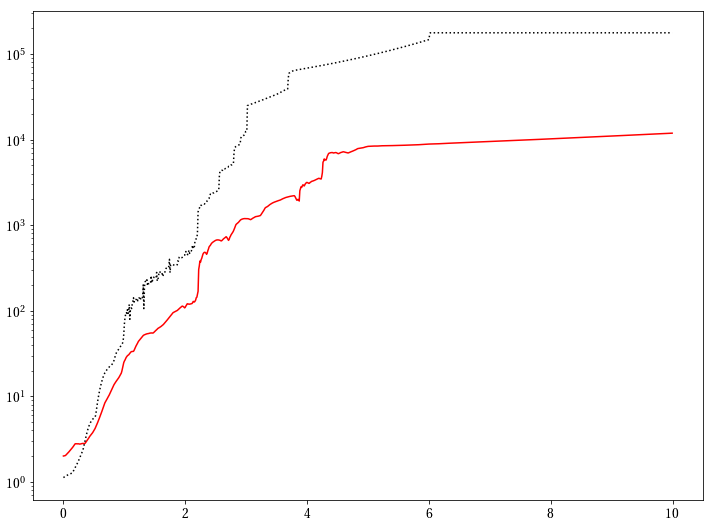

In [18]:
i =  15

print('HI:', dataset['HI']['g_max'][i][-1])

print('noHI:', dataset['noHI']['g_max'][i][-1])


plt.rcParams['figure.figsize'] = [12, 9]
#plt.semilogy(dataset['HI']['t'], dataset['HI']['g_max'][i], 'k-', label='HI')
plt.semilogy(dataset['HI']['t'], dataset['HI']['g_max_denoise'][i], 'r-', label='HI')
plt.semilogy(dataset['noHI']['t'], dataset['noHI']['g_max'][i], 'k:', label='no HI')

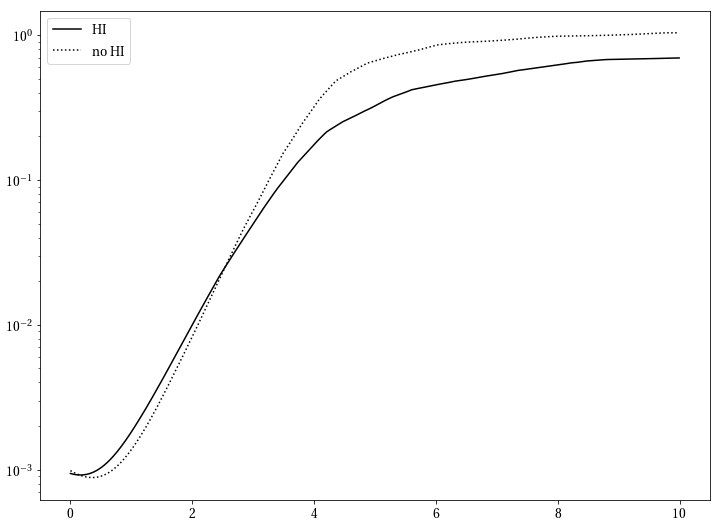

In [19]:
plt.semilogy(dataset['HI']['t'], dataset['HI']['tr(A)'], 'k-', label='HI')
plt.semilogy(dataset['noHI']['t'], dataset['noHI']['tr(A)'], 'k:', label='no HI')
plt.legend()

(0, 10)

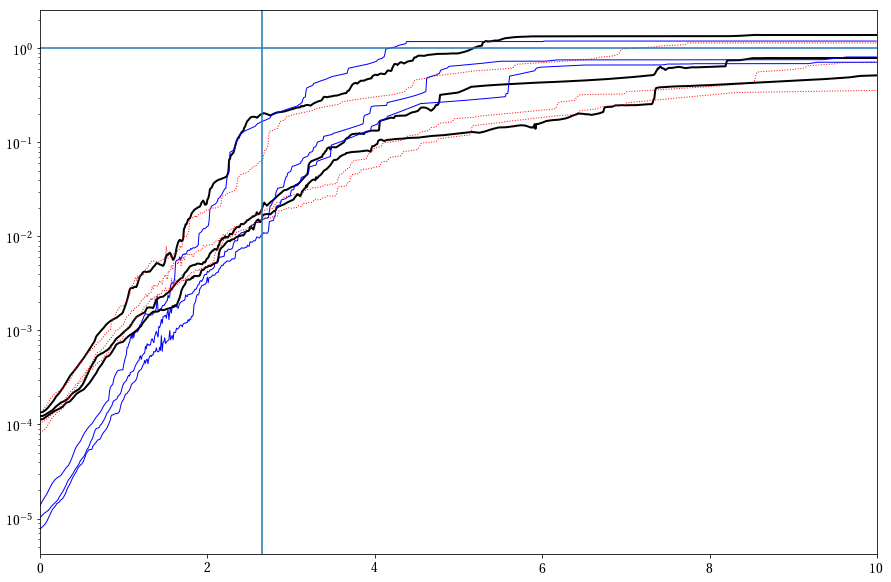

In [20]:
plt.rcParams['figure.figsize'] = [15, 10]
pool = []

for i in pool:
    plt.semilogy(dataset['HI']['t'], dataset['HI']['L2'][i], 'k-', linewidth=1)
for i in pool:
    plt.semilogy(dataset['noHI']['t'], dataset['noHI']['L2'][i], 'b-', linewidth=1)
    

for i in [97, 50, 25]:
    plt.semilogy(dataset['HI']['t'], np.percentile(dataset['HI']['L2'], i, axis=0), 'k-', linewidth=2)
    plt.semilogy(dataset['noHI']['t'], np.percentile(dataset['noHI']['L2'], i, axis=0), 'b-', linewidth=1)
    plt.semilogy(dataset['noHI']['t']+dataset['noHI']['t']**3/25, np.percentile(dataset['noHI']['L2'], i, axis=0)**0.8, 'r:', linewidth=1)

plt.axvline(np.log(200)/2)
plt.axhline(1)
plt.xlim(0,10)


In [21]:
# Scission just as function of normalised L2
ws = np.logspace(-1,2,100)


cs_HI = []

for w in ws:

    events = np.zeros_like(dataset['HI']['t'])
    for L2t in dataset['HI']['L2']:
        for i, L2eff in enumerate(L2t):
            
            if L2eff > 1./w:
                # Non-specific scission
                events[i] += 1
                break
                
    c = 1. - np.cumsum(events)/n_ensemble
    cs_HI.append(c)

cs_HI = np.array(cs_HI)


cs_noHI = []

for w in ws:

    events = np.zeros_like(dataset['noHI']['t'])
    for L2t in dataset['noHI']['L2']:
        for i, L2eff in enumerate(L2t):
            
            if L2eff > 1./w:
                # Non-specific scission
                events[i] += 1
                break
                
    c = 1. - np.cumsum(events)/n_ensemble
    cs_noHI.append(c)

cs_noHI = np.array(cs_noHI)


In [22]:
def build_model(params):
    c_model = np.ones_like(cs_HI)
    
    for i, w in enumerate(ws):
        kappa = params[0] + params[1]*np.log(w)**2
        f = 1./(1 + np.exp(-np.log(w)/params[2]))
        g = params[3]*np.log((1 + np.exp((dataset['HI']['t'] - np.log(params[5])/2 + params[4]*np.log(w))/params[3])))
        
        c_model[i] = np.exp(-kappa*f*g)
        
    return c_model


def loss(params):
    return np.sum((cs_HI-build_model(params))**2)


from scipy.optimize import minimize
                                    
res = minimize(loss, [0.16, 0.16, 0.2, 0.15, 0.35, n_links])

print(res.message)
pms = np.sqrt(np.diag(res.hess_inv))
params = ['kappa_0', 'kappa_1', 'gamma_0', 'gamma_1', 'beta_0', 'xi']
for param, value, pm in zip(params, res.x, pms):
    print(f"{param} = {value:.3f} ± {pm:.3f}")

cs_model = build_model(res.x)

Desired error not necessarily achieved due to precision loss.
kappa_0 = 0.149 ± 0.005
kappa_1 = 0.132 ± 0.005
gamma_0 = 0.124 ± 0.013
gamma_1 = 0.154 ± 0.021
beta_0 = 0.341 ± 0.011
xi = 1376.834 ± 102.641


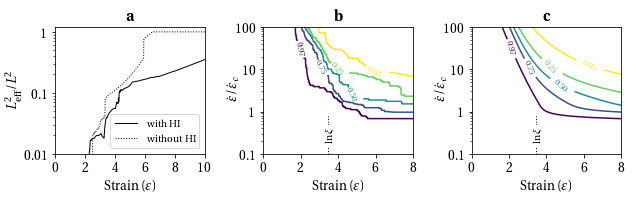

In [23]:
plt.rcParams['figure.figsize'] = [9, 3]
fig, ax = plt.subplots(ncols=3)

levels = [0.03, 0.25, 0.5, 0.75, 0.97]
label_pos = [(5,3),
             (4,10),
             (3.8,2),
             (2.8,10),
             (2,30)
            ]
#ccols = ['#dde318', '#5ec962', '#21918c', '#3b528b', '#440154']

epsilon = dataset['HI']['t']

ax[0].semilogy(epsilon, dataset['HI']['L2'][4]/0.650506, 'k-', linewidth=1, label='with HI')
ax[0].semilogy(epsilon, dataset['noHI']['L2'][4]/0.650506, 'k:', linewidth=1, label='without HI')
ax[0].set_xlim(0, 10)
ax[0].set_xticks(ticks=[0, 2, 4, 6, 8, 10])
ax[0].set_xlabel(r'Strain ($\varepsilon$)')
ax[0].set_ylim(0.01, 1.2)
ax[0].set_ylabel(r'$L_\mathrm{eff}^2/L^2$', labelpad=0)
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax[0].legend(fontsize=11, loc='lower right')
ax[0].set_title(r'\textbf a')


CS = ax[1].contour(epsilon, ws, cs_HI, levels, cmap='viridis_r')
ax[1].set_yscale('log')
for level, position in zip(levels, label_pos):
    ax[1].clabel(CS, [level], inline=True, fontsize=9, fmt='%1.2f', manual=[position])
ax[1].set_xlabel(r'Strain ($\varepsilon$)')
ax[1].set_ylabel(r'$\dot\varepsilon/\dot\varepsilon_c$', labelpad=-5)
ax[1].text(np.log(n_links)/2-0.2, 0.25, r'$\ln \xi$', bbox={'fc': '1', 'ec': 'None'}, rotation=90, fontsize=11)
ax[1].set_ylim(0.1, 100)
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax[1].set_xlim(0, 8)
ax[1].set_xticks(ticks=[0, 2, 4, 6, 8])
#plt.axhline(1, ls=':')
ax[1].axvline(np.log(n_links)/2, 0, 0.3, ls=':', color='k', linewidth=1)
ax[1].set_title(r'\textbf b')


CS = ax[2].contour(epsilon, ws, cs_model, levels, cmap='viridis_r') 
ax[2].set_yscale('log')
for level, position in zip(levels, label_pos):
    ax[2].clabel(CS, [level], inline=True, fontsize=9, fmt='%1.2f', manual=[position])
ax[2].set_xlabel(r'Strain ($\varepsilon$)')
ax[2].set_ylabel(r'$\dot\varepsilon/\dot\varepsilon_c$', labelpad=-5)
ax[2].text(np.log(n_links)/2-0.2, 0.25, r'$\ln \xi$', bbox={'fc': '1', 'ec': 'None'}, rotation=90, fontsize=11)
ax[2].set_ylim(0.1, 100)
ax[2].yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax[2].set_xlim(0, 8)
ax[2].set_xticks(ticks=[0, 2, 4, 6, 8])
#plt.axhline(1, ls=':')
ax[2].axvline(np.log(n_links)/2, 0, 0.3, ls=':', color='k', linewidth=1)
ax[2].set_title(r'\textbf c')

plt.tight_layout()
plt.savefig('plot_HI.pdf') 

In [24]:
dataset['noHI']['L2'][4][-1]

0.6505065170763864

## Mechanochemical activation versus scission

In [25]:
## With PD = 1.01

data = dataset['elongation_0_noBF_DP1.01']
n_ensemble = 1000
n_links = 1000

Wi_c = 200
Wi_m = 100
threshold = Wi_c/(8*0.0142)
mechanophore = Wi_m/(8*0.0142)
print(threshold, mechanophore)

cs_2 = []

# Tensions are going to be rescaled with Wi
Wis = np.logspace(np.log10(Wi_m)-1,np.log10(Wi_m)+2,100)

for Wi in Wis:

    events = np.zeros_like(data['t'])
    for tension_max, tension_centre in zip(Wi*data['L2']/(0.0142*8), Wi*data['M2']/(0.0142*8)):
        for i, (g_max, g_12) in enumerate(zip(tension_max, tension_centre)):
            
            if g_max > threshold or g_12 > mechanophore:
                # Non-specific scission
                events[i] += 1
                break
                
    c = 1. - np.cumsum(events)/n_ensemble
    cs_2.append(c)

cs_2 = np.array(cs_2)

1760.5633802816901 880.2816901408451


In [26]:
Wi_c = 500
Wi_m = 100
threshold = Wi_c/(8*0.0142)
mechanophore = Wi_m/(8*0.0142)
print(threshold, mechanophore)

cs_5 = []

# Tensions are going to be rescaled with Wi
Wis = np.logspace(np.log10(Wi_m)-1,np.log10(Wi_m)+2,100)

for Wi in Wis:

    events = np.zeros_like(data['t'])
    for tension_max, tension_centre in zip(Wi*data['L2']/(0.0142*8), Wi*data['M2']/(0.0142*8)):
        for i, (g_max, g_12) in enumerate(zip(tension_max, tension_centre)):
            
            if g_max > threshold or g_12 > mechanophore:
                # Non-specific scission
                events[i] += 1
                break
                
    c = 1. - np.cumsum(events)/n_ensemble
    cs_5.append(c)

cs_5 = np.array(cs_5)

4401.408450704225 880.2816901408451


In [27]:
def build_model(params):
    c_model = np.ones_like(cs_5)
    
    for i, w in enumerate(Wis/Wi_m):
        kappa = params[0] + params[1]*np.log(w)**2
        f = 1./(1 + np.exp(-np.log(w)/params[2]))
        g = params[3]*np.log((1 + np.exp((dataset['elongation_0_noBF_DP1.01']['epsilon'] - np.log(n_links)/2 + params[4]*np.log(w))/params[3])))
        
        c_model[i] = np.exp(-kappa*f*g)
        
    return c_model


def loss(params):
    return np.sum((cs_5-build_model(params))**2)


from scipy.optimize import minimize
                                    
res = minimize(loss, [0.4, 0.2, 0.1, 0.1, 0.25, 1000])

print(res.message)
pms = np.sqrt(np.diag(res.hess_inv))
params = ['kappa_0', 'kappa_1', 'gamma_0', 'gamma_1', 'beta_0', 'N']
for param, value, pm in zip(params, res.x, pms):
    print(f"{param} = {value:.3f} ± {pm:.3f}")

c_model = build_model(res.x)

/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


Desired error not necessarily achieved due to precision loss.
kappa_0 = 0.410 ± 0.010
kappa_1 = 0.140 ± 0.010
gamma_0 = 0.078 ± 0.005
gamma_1 = 0.216 ± 0.020
beta_0 = 0.163 ± 0.012
N = 1000.000 ± 1.000


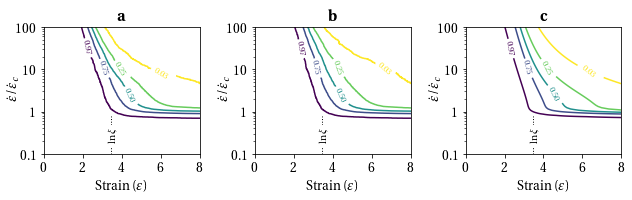

In [28]:
plt.rcParams['figure.figsize'] = [9, 3]
fig, ax = plt.subplots(ncols=3)

levels = [0.03, 0.25, 0.5, 0.75, 0.97]
label_pos = [(5,3),
             (4,10),
             (3.8,2),
             (2.8,10),
             (2,30)
            ]


CS = ax[0].contour(data['epsilon'], Wis/Wi_m, cs_2, levels, cmap='viridis_r') # viridis_r, YlGnBu
ax[0].set_yscale('log')
for level, position in zip(levels, label_pos):
    ax[0].clabel(CS, [level], inline=True, fontsize=9, fmt='%1.2f', manual=[position])
ax[0].set_xlabel('Strain ($\\varepsilon$)')
ax[0].set_ylabel('$\\dot\\varepsilon/\\dot\\varepsilon_c$', labelpad=-5)
ax[0].text(np.log(n_links)/2-0.2, 0.25, '$\\ln \\xi$', bbox={'fc': '1', 'ec': 'None'}, rotation=90, fontsize=11)
ax[0].set_ylim(0.1, 100)
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax[0].set_xlim(0, 8)
ax[0].set_xticks(ticks=[0, 2, 4, 6, 8])
#plt.axhline(1, ls=':')
ax[0].axvline(np.log(n_links)/2, 0, 0.3, ls=':', color='k', linewidth=1)
ax[0].set_title('\\textbf a')


CS = ax[1].contour(data['epsilon'], Wis/Wi_m, cs_5, levels, cmap='viridis_r')
ax[1].set_yscale('log')
for level, position in zip(levels, label_pos):
    ax[1].clabel(CS, [level], inline=True, fontsize=9, fmt='%1.2f', manual=[position])
ax[1].set_xlabel('Strain ($\\varepsilon$)')
ax[1].set_ylabel('$\\dot\\varepsilon/\\dot\\varepsilon_c$', labelpad=-5)
ax[1].text(np.log(n_links)/2-0.2, 0.25, '$\\ln \\xi$', bbox={'fc': '1', 'ec': 'None'}, rotation=90, fontsize=11)
ax[1].set_ylim(0.1, 100)
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax[1].set_xlim(0, 8)
ax[1].set_xticks(ticks=[0, 2, 4, 6, 8])
#plt.axhline(1, ls=':')
ax[1].axvline(np.log(n_links)/2, 0, 0.3, ls=':', color='k', linewidth=1)
ax[1].set_title('\\textbf b')


CS = ax[2].contour(data['epsilon'], Wis/Wi_m, c_model, levels, cmap='viridis_r') 
ax[2].set_yscale('log')
for level, position in zip(levels, label_pos):
    ax[2].clabel(CS, [level], inline=True, fontsize=9, fmt='%1.2f', manual=[position])
ax[2].set_xlabel('Strain ($\\varepsilon$)')
ax[2].set_ylabel('$\\dot\\varepsilon/\\dot\\varepsilon_c$', labelpad=-5)
ax[2].text(np.log(n_links)/2-0.2, 0.25, '$\\ln \\xi$', bbox={'fc': '1', 'ec': 'None'}, rotation=90, fontsize=11)
ax[2].set_ylim(0.1, 100)
ax[2].yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax[2].set_xlim(0, 8)
ax[2].set_xticks(ticks=[0, 2, 4, 6, 8])
#plt.axhline(1, ls=':')
ax[2].axvline(np.log(n_links)/2, 0, 0.3, ls=':', color='k', linewidth=1)
ax[2].set_title('\\textbf c')

plt.tight_layout()
plt.savefig('plot_distributions_mechanophores.pdf') 

## Efficiency

In [29]:
data = dataset['elongation_0_noBF_DP1.01']
n_ensemble = 1000
n_links = 1000
Wi_c = 200
Wi_m = 100
threshold = Wi_c/(8*0.0142)
mechanophore = Wi_m/(8*0.0142)


intact_chains = np.zeros_like(cs_2)
dw_to_scission = np.zeros_like(cs_2)
dw_to_mechanophore = np.zeros_like(cs_2)
dh_to_scission = np.zeros_like(cs_2)
dh_to_mechanophore = np.zeros_like(cs_2)

for i, Wi in enumerate(Wis):
    for j, h in enumerate(data['epsilon']):
        # Distributions
        tension_maxs, tension_centres = Wi*data['L2'][:,j]/(0.0142*8), Wi*data['M2'][:,j]/(0.0142*8)
        # Conditional distribution
        T = (tension_maxs < threshold) * (tension_centres < mechanophore)
        intact_chains[i, j] = np.sum(T)/n_ensemble
        
        # strain rate increment
        i_step = 2
        if i < len(Wis)-i_step:
            # From this point, we increase Wi
            T_dw = tension_centres[T]/Wi*Wis[i+i_step] > mechanophore
            dw_to_mechanophore[i, j] = np.sum(T_dw)/n_ensemble

            T_dw = (tension_maxs[T]/Wi*Wis[i+i_step] > threshold) * (tension_centres[T]/Wi*Wis[i+i_step] < mechanophore)
            dw_to_scission[i, j] = np.sum(T_dw)/n_ensemble
        
        # Strain increment
        j_step = 20
        if j < len(data['epsilon']) - j_step:
            # From this point we increase h
            tension_maxs2, tension_centres2 = Wi*data['L2'][:,j+j_step]/(0.0142*8), Wi*data['M2'][:,j+j_step]/(0.0142*8)
            T_dh = tension_centres2[T] > mechanophore
            dh_to_mechanophore[i, j] = np.sum(T_dh)/n_ensemble

            T_dh = (tension_maxs2[T] > threshold) * (tension_centres2[T] < mechanophore)
            dh_to_scission[i, j] = np.sum(T_dh)/n_ensemble

/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/home/etienne/miniconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


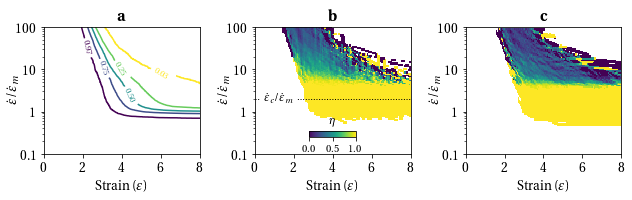

In [30]:
yield_dh = dh_to_mechanophore/(dh_to_mechanophore + dh_to_scission)
yield_dw = dw_to_mechanophore/(dw_to_mechanophore + dw_to_scission)
intact_chains_clear = intact_chains.copy()
intact_chains_clear[intact_chains_clear==1] = np.nan
intact_chains_clear[intact_chains_clear==0] = np.nan
intact_chains_clear[~np.isnan(intact_chains_clear)] = 0.05

from mpl_toolkits.axes_grid1.inset_locator import inset_axes


plt.rcParams['figure.figsize'] = [9, 3]
fig, ax = plt.subplots(ncols=3)


#ax[0].pcolormesh(data['epsilon'], Wis/Wi_m, intact_chains_clear, rasterized=True, cmap='Greys', vmin=0, vmax=1)
CS = ax[0].contour(data['epsilon'], Wis/Wi_m, cs_2, levels, cmap='viridis_r') # viridis_r, YlGnBu
ax[0].set_yscale('log')
for level, position in zip(levels, label_pos):
    ax[0].clabel(CS, [level], inline=True, fontsize=9, fmt='%1.2f', manual=[position])
ax[0].set_xlabel('Strain ($\\varepsilon$)')
ax[0].set_ylabel('$\\dot\\varepsilon/\\dot\\varepsilon_m$', labelpad=-5)
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax[0].set_ylim(0.1, 100)
ax[0].set_xlim(0, 8)
ax[0].set_xticks(ticks=[0, 2, 4, 6, 8])
ax[0].set_title('\\textbf a')


im1 = ax[1].pcolormesh(data['epsilon'], Wis/Wi_m, yield_dh, rasterized=True)
ax[1].set_yscale('log')
ax[1].set_ylim(0.1, 100)
ax[1].set_ylabel('$\\dot\\varepsilon/\\dot\\varepsilon_m$', labelpad=-5)
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax[1].set_xlim(0, 8)
ax[1].set_xticks(ticks=[0, 2, 4, 6, 8])
ax[1].set_xlabel('Strain ($\\varepsilon$)')
ax[1].axhline(Wi_c/Wi_m, ls=':', color='k', linewidth=1)
ax[1].text(0.5, 0.8*Wi_c/Wi_m, r'$\dot\varepsilon_c/\dot\varepsilon_m$', bbox={'fc': '1', 'ec': 'None'}, fontsize=12)
ax[1].set_title('\\textbf b')

axins1 = inset_axes(
    ax[1],
    width="30%",  # width: 50% of parent_bbox width
    height="5%",  # height: 5%
    loc='lower center',
    borderpad=1.2
)
axins1.tick_params(labelsize=11)
axins1.set_title(r'$\eta$', fontsize=12)
fig.colorbar(im1, cax=axins1, orientation="horizontal", ticks=[0, 0.5, 1])

ax[2].pcolormesh(data['epsilon'], Wis/Wi_m, yield_dw, rasterized=True)
ax[2].set_yscale('log')
ax[2].set_ylabel('$\\dot\\varepsilon/\\dot\\varepsilon_m$', labelpad=-5)
ax[2].set_ylim(0.1, 100)
ax[2].yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax[2].set_xlim(0, 8)
ax[2].set_xticks(ticks=[0, 2, 4, 6, 8])
ax[2].set_xlabel('Strain ($\\varepsilon$)')
ax[2].set_title('\\textbf c')

plt.tight_layout()
plt.savefig('plot_efficiency.pdf', dpi=300) 

### Extract analytic model

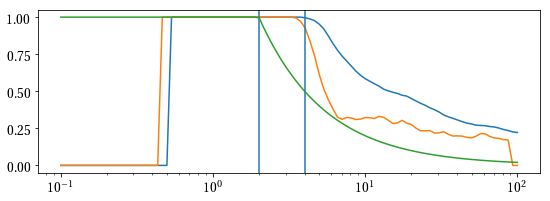

In [31]:
weights_h = dh_to_mechanophore + dh_to_scission + 1e-9
weights_w = dw_to_mechanophore + dw_to_scission + 1e-9
yield_dh2 = yield_dh.copy()
yield_dw2 = yield_dw.copy()
yield_dh2[np.isnan(yield_dh2)] = 0
yield_dw2[np.isnan(yield_dw2)] = 0


plt.semilogx(Wis/Wi_m, np.average(yield_dh2, axis=1, weights=weights_h))
plt.semilogx(Wis/Wi_m, np.average(yield_dw2, axis=1, weights=weights_w))
plt.axvline(Wi_c/Wi_m)
plt.axvline(3*Wi_c/Wi_m-2)


w = Wis/Wi_m
curve = ((3*Wi_c/Wi_m-2)/w)**0.75
curve[curve>1] = 1
#curve2 = 1./(1 + np.exp((np.log(w)-np.log(3*Wi_c/Wi_m-2))/0.1))**0.1


curve2 = 1./w*Wi_c/Wi_m
curve2[curve2>1] = 1

#plt.semilogx(w, curve)
plt.semilogx(w, curve2)

## Closure simulation

In [99]:
# Cf paper notations
def F(x):
    return 1./(1 + np.exp(-x))

def G(x):
    return np.log(1. + np.exp(x))


kappa_0 = 0.36
kappa_1 = 0.36
gamma_0 = 0.08
gamma_1 = 0.2
beta_0 = 0.23

gamma_2 = 0.1

def k_h(h, w):
    out = kappa_0 + kappa_1*np.log(w)**2
    out *= F(np.log(w)/gamma_0)
    out *= F((h + beta_0*np.log(w))/gamma_1)
    return out

def k_w(h, w):
    x1 = np.log(w)/gamma_0
    x2 = (h + beta_0*np.log(w))/gamma_1
    out = 2*kappa_1*np.log(w)/w*F(x1)*gamma_1*G(x2)
    out += (kappa_0 + kappa_1*np.log(w)**2)/gamma_0/w*F(x1)*F(-x1)*gamma_1*G(x2)
    out += beta_0*(kappa_0 + kappa_1*np.log(w)**2)/w*F(x1)*F(x2)
    return out
    
def eta(w):
    return (1 + (w/w_0)**(1./gamma_2))**(-gamma_2)
    

### Load data for fine-tuning

Data will be added to the `dataset` dictionary.

In [188]:
Wi_max = 1000                       # Peak Weissenberg number in simulations
n_links = 1000                      # Number of segments in the Kramers chain
n_ensemble = 100                     # Number of molecules to simulate

# Scenarios for fine tuning
scenarios = [
    'contraction_0_PD',
    'contraction_2_PD',
    'contraction_4_PD',
    'contraction_5_PD',
    'contraction_6_PD',
    'sonication_0_PD',
    'sonication_1_PD',
    'sonication_2_PD',
    'sonication_3_PD',
    'sonication_4_PD',
    'turbulence_0_PD',
    'turbulence_1_PD',
    'turbulence_2_PD',
    'turbulence_3',
    'turbulence_4',
    'inkjet_0_PD',
    'inkjet_1_PD',
    'inkjet_2_PD',
    'inkjet_3_PD',
    'inkjet_4_PD'
]


for scenario in scenarios:
    with np.load(f"{data_folder}/{scenario}_Wi{Wi_max}_nlinks{n_links}_nmol{n_ensemble}.npz") as data:
        temp = dict(data)
        # Rename and normalise variables
        tau = 0.0142*n_links**2
        temp['A'] = temp.pop('A_average')/n_links**2
        temp['∇U'] = temp.pop('gradU')*tau
        temp['t'] = temp['t']/tau
        # Add transposed variables (not used)
        #temp['∇Uᵀ'] = np.transpose(temp['∇U'], axes=(0, 2, 1))
        
        # Add features
        temp['tr(A)'] = np.trace(temp['A'], axis1=1, axis2=2)
        temp['tr(A∇U)'] = np.trace(temp['A']@temp['∇U'], axis1=1, axis2=2)     
        
        # Flow properties (not used)
        # temp['epsilon_dot'] = np.linalg.eigvalsh(0.5*(temp['∇U'] + temp['∇Uᵀ']))
        
        # Effective principal strain rate
        temp['epsilon_dot_eff'] = temp['tr(A∇U)']/temp['tr(A)']
        
        # Hencky strain (not used)
        # epsilon = np.zeros_like(temp['t'])
        
        # Buckling strain
        phi = np.zeros_like(temp['t'])
        
        # Effective positive strain
        epsilon_eff = np.zeros_like(temp['t'])
        
        for i, dt in enumerate(np.diff(temp['t'])):
            # epsilon[i+1] = np.amax(temp['epsilon_dot'][i])*dt + epsilon[i]
            
            # Buckling strain rate
            if temp['epsilon_dot_eff'][i] < 0 or phi[i] < -1e-6:
                epsilon_dot_b = temp['epsilon_dot_eff'][i]
            else:
                epsilon_dot_b = 0.
            phi[i+1] = (epsilon_dot_b + phi[i]/dt)/(1./dt + 1.)
            
            epsilon_eff[i+1] = (temp['epsilon_dot_eff'][i] - epsilon_dot_b + epsilon_eff[i]/dt)/(1./dt + 1.)
        # temp['epsilon'] = epsilon
        temp['phi'] = phi
        temp['epsilon_eff'] = epsilon_eff


        # Save
        dataset[scenario] = temp

### Compute mechanochemistry from BD simulations

In [191]:
# Compute mechanochemistry for Lagrangian trajectories
Wi_m = 50
Wi_c = 50


threshold = Wi_c/(8*0.0142)
mechanophore = Wi_m/(8*0.0142)
w_0 = 4*Wi_c/Wi_m - 3

for scenario in scenarios:
    
    t = dataset[scenario]['t']
    
    # Concentration of intact chains according to closure
    ci_model = np.ones_like(t)
    
    # Concentration of activated mechanophore (closure)
    cm_model = np.zeros_like(t)
    
    for i, (dt, dh, dw) in enumerate(zip(np.diff(t), np.diff(dataset[scenario]['epsilon_eff']), np.diff(dataset[scenario]['epsilon_dot_eff']/Wi_m))):
        # Closure
        h = dataset[scenario]['epsilon_eff'][i] - 5./12*np.log(n_links)
        w = dataset[scenario]['epsilon_dot_eff'][i]/Wi_m
        if w <= 0:
            k = 0
        else:   
            k = max(0, k_h(h, w)*dh/dt) + max(0, k_w(h, w)*dw/dt)
        # All events:
        ci_model[i+1] = ci_model[i]/(1. + dt*k)
        
        # Mechanophore:
        dc = ci_model[i+1] - ci_model[i]
        cm_model[i+1] = cm_model[i] - eta(w)*dc
        
    # BD simulation
    events = np.zeros_like(t)
    events_mech = np.zeros_like(t)
    
    for g_max_series, g_12_series in zip(dataset[scenario]['g_max'], dataset[scenario]['g_12']):
        for i, (g_max, g_12) in enumerate(zip(g_max_series, g_12_series)):           
            if g_12 > mechanophore:
                # Mechanophore activation
                events_mech[i] += 1
                events[i] += 1
                break
            
            if g_max > threshold:
                # Non-specific scission
                events[i] += 1
                break
                
    ci = 1. - np.cumsum(events)/n_ensemble
    cm = np.cumsum(events_mech)/n_ensemble
    
    dataset[scenario]['ci'] = ci
    dataset[scenario]['cm'] = cm
    
    dataset[scenario]['ci_model'] = ci_model
    dataset[scenario]['cm_model'] = cm_model


In [192]:
# Inspect
def view_scission(scenario, zoom):
    t = dataset[scenario]['t'][zoom[0]:zoom[1]]
    
    plt.rcParams['figure.figsize'] = [12, 12]
    fig, ax = plt.subplots(nrows=3)
    ax[0].plot(t, dataset[scenario]['ci'][zoom[0]:zoom[1]], 'k', label='Intact chains')
    ax[0].plot(t, dataset[scenario]['ci_model'][zoom[0]:zoom[1]], 'k:', label='Intact chains (closure)')
    ax[0].plot(t, dataset[scenario]['cm'][zoom[0]:zoom[1]], 'r', label='Mechanophore')
    ax[0].plot(t, dataset[scenario]['cm_model'][zoom[0]:zoom[1]], 'r:', label='Mechanophore (closure)')
    ax[0].set_ylabel('Concentration')
    ax[0].set_xlabel(r'Time ($t/\tau$)')
    ax[0].legend()
    
    ax[1].plot(t, dataset[scenario]['epsilon_eff'][zoom[0]:zoom[1]], label='Positive strain')
    ax[1].plot(t, dataset[scenario]['phi'][zoom[0]:zoom[1]], label='Buckling strain')
    ax[1].set_ylabel('Effective strain')
    ax[1].set_xlabel(r'Time ($t/\tau$)')
    ax[1].legend()
    
    ax[2].semilogy(t, dataset[scenario]['epsilon_dot_eff'][zoom[0]:zoom[1]])
    ax[2].set_ylabel('Effective strain rate')
    ax[2].set_xlabel(r'Time ($t/\tau$)')
    
    plt.show()

    
x_widget = widgets.Dropdown(options=scenarios, value=scenarios[0], description='Scenario:')
y_widget = widgets.IntRangeSlider(description='Zoom:', continuous_update=False)    

def update_models(*args):
    tmax = len(dataset[x_widget.value]['t'])
    y_widget.value=[0, tmax]
    y_widget.min=0
    y_widget.max=tmax
x_widget.observe(update_models)
    
ws = interactive(view_scission, 
                 scenario=x_widget,
                 zoom=y_widget
                )
ws

interactive(children=(Dropdown(description='Scenario:', options=('contraction_0_PD', 'contraction_2_PD', 'cont…

## Fine tuning

Now that we have an explainable model, we can use the whole dataset at finite Weissenberg number to fine-tune the parameters.

### Fine tuning intact chains model
Le loss function is only given by the error in intact chains concentration

In [182]:
def simulate_mechanochemistry(params):
    
    kappa_0, kappa_1, beta_0, gamma_0, gamma_1 = params    
    
    def k_h(h, w):
        out = kappa_0 + kappa_1*np.log(w)**2
        out *= F(np.log(w)/gamma_0)
        out *= F((h + beta_0*np.log(w))/gamma_1)
        return out

    def k_w(h, w):
        x1 = np.log(w)/gamma_0
        x2 = (h + beta_0*np.log(w))/gamma_1
        out = 2*kappa_1*np.log(w)/w*F(x1)*gamma_1*G(x2)
        out += (kappa_0 + kappa_1*np.log(w)**2)/gamma_0/w*F(x1)*F(-x1)*gamma_1*G(x2)
        out += beta_0*(kappa_0 + kappa_1*np.log(w)**2)/w*F(x1)*F(x2)
        return out
    
    for scenario in scenarios:
    
        t = dataset[scenario]['t']

        # Concentration of intact chains according to closure
        ci_model = np.ones_like(t)

        for i, (dt, dh, dw) in enumerate(zip(np.diff(t), np.diff(dataset[scenario]['epsilon_eff']), np.diff(dataset[scenario]['epsilon_dot_eff']/Wi_m))):
            # Closure
            h = dataset[scenario]['epsilon_eff'][i] - 5./12*np.log(n_links)
            w = dataset[scenario]['epsilon_dot_eff'][i]/Wi_m
            if w <= 0:
                k = 0
            else:   
                k = max(0, k_h(h, w)*dh/dt) + max(0,k_w(h, w)*dw/dt)
            
            # All events:
            ci_model[i+1] = ci_model[i]/(1. + dt*k)
        
        # Update dataset
        dataset[scenario]['ci_model'] = ci_model


def loss(params):
    simulate_mechanochemistry(params)
    s = 0
    for scenario in scenarios:
        # Test function (define loss only in interesting regions)
        T1 = np.logical_and(dataset[scenario]['ci'] > 0 , dataset[scenario]['ci'] < 1)
        T2 = np.logical_and(dataset[scenario]['ci_model'] > 0 , dataset[scenario]['ci_model'] < 1)
        T = np.logical_or(T1, T2)

        dataset[scenario]['error_ci'] = np.average((dataset[scenario]['ci'][T]-dataset[scenario]['ci_model'][T])**2)
        s += dataset[scenario]['error_ci']
    print(s, end="\r")
    return s

In [183]:
kappa_0 = 0.36
kappa_1 = 0.36
gamma_0 = 0.08
gamma_1 = 0.2
beta_0 = 0.23

res = minimize(loss, [kappa_0, kappa_1, beta_0, gamma_0, gamma_1])#, bounds=[(0.01,2)]*5)

KeyboardInterrupt: 

In [173]:
print(res)

params = ['kappa_0', 'kappa_1', 'beta_0', 'gamma_0', 'gamma_1', 'gamma_2']
for param, value, pm in zip(params, res.x, pms):
    print(f"{param} = {value:.3f} ± {pm:.3f}")

      fun: 0.015393288486722839
 hess_inv: array([[ 9.17179300e+01, -1.61727457e+00, -1.31574106e+01,
         1.31864318e+01, -6.84860273e-01],
       [-1.61727457e+00,  4.32574021e-01, -1.59236126e-02,
        -2.34219640e-01,  1.19124783e-01],
       [-1.31574106e+01, -1.59236126e-02,  2.11729002e+00,
        -1.89395374e+00, -1.03837931e-01],
       [ 1.31864318e+01, -2.34219640e-01, -1.89395374e+00,
         2.91266242e+00, -9.65184497e-02],
       [-6.84860273e-01,  1.19124783e-01, -1.03837931e-01,
        -9.65184497e-02,  4.68297173e-01]])
      jac: array([7.03873613e-03, 3.48635216e-03, 1.76532847e-02, 7.42787961e-06,
       4.52801085e-03])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 554
      nit: 15
     njev: 91
   status: 2
  success: False
        x: array([0.0013671 , 0.19316155, 0.26099707, 0.0270916 , 0.14974176])
kappa_0 = 0.001 ± 0.010
kappa_1 = 0.193 ± 0.010
beta_0 = 0.261 ± 0.005
gamma_0 = 0.027 ± 0.020
gamma_1 = 0.150 ± 

In [168]:
ws

interactive(children=(Dropdown(description='Scenario:', index=14, options=('contraction_0_PD', 'contraction_2_…

### Fine tuning activation efficiency

In [110]:
def simulate_mechanochemistry(params):
    
    gamma_2, w_0 = params

    def eta(w):
#        effi = 1/w*beta_1
#        if effi > 1:
#            return 1
#        else:
#            return effi
        
        return (1+(w_0/w)**(1./0.1))**(-0.1)
    
    for scenario in scenarios:

        # Concentration of activated mechanophore (closure)
        cm_model = np.zeros_like(dataset[scenario]['t'])

        for i, dc in enumerate(np.diff(dataset[scenario]['ci_model'])):
            # Closure
            w = dataset[scenario]['epsilon_dot_eff'][i]/Wi_m
            if w <= 0:
                effi = 0
            else:   
                effi = eta(w)

            # Mechanophore:
            cm_model[i+1] = cm_model[i] - effi*dc

        dataset[scenario]['cm_model'] = cm_model


def loss(params):
    simulate_mechanochemistry(params)
    s = 0
    for scenario in scenarios:
        # Test function (define loss only in interesting regions)
        T1 = np.logical_and(dataset[scenario]['cm'] > 0 , dataset[scenario]['cm'] < 1)
        T2 = np.logical_and(dataset[scenario]['cm_model'] > 0 , dataset[scenario]['cm_model'] < 1)
        T = np.logical_or(T1, T2)

        dataset[scenario]['error_cm'] = np.average((dataset[scenario]['cm'][T]-dataset[scenario]['cm_model'][T])**2)
        
        s += dataset[scenario]['error_cm']
    print(s, params,  end="\r")
    return s

res = minimize(loss, [0.1, 4*Wi_c/Wi_m - 3])#, bounds=[(0.01,1),(0.1, 50)])

In [108]:
res

      fun: 0.001901580725878373
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.00000000e+00, 9.40009711e-06])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 39
      nit: 6
     njev: 13
   status: 0
  success: True
        x: array([ 0.1       , 23.49859827])

In [109]:
ws

interactive(children=(Dropdown(description='Scenario:', index=1, options=('contraction_0_PD', 'contraction_2_P…

### Selected plots

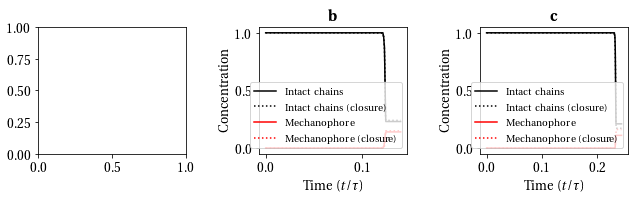

In [98]:


plt.rcParams['figure.figsize'] = [9, 3]
fig, ax = plt.subplots(ncols=3)

scenario = 'contraction_5_PD'
t = dataset[scenario]['t']
zoom = [0, None]

ax[1].plot(t, dataset[scenario]['ci'][zoom[0]:zoom[1]], 'k', label='Intact chains')
ax[1].plot(t, dataset[scenario]['ci_model'][zoom[0]:zoom[1]], 'k:', label='Intact chains (closure)')
ax[1].plot(t, dataset[scenario]['cm'][zoom[0]:zoom[1]], 'r', label='Mechanophore')
ax[1].plot(t, dataset[scenario]['cm_model'][zoom[0]:zoom[1]], 'r:', label='Mechanophore (closure)')
ax[1].set_ylabel('Concentration')
ax[1].set_xlabel(r'Time ($t/\tau$)')
ax[1].legend()
ax[1].legend(fontsize=11, loc='lower right')
ax[1].set_title(r'\textbf b')

scenario = 'sonication_0_PD'
t = dataset[scenario]['t']
zoom = [0, None]

ax[2].plot(t, dataset[scenario]['ci'][zoom[0]:zoom[1]], 'k', label='Intact chains')
ax[2].plot(t, dataset[scenario]['ci_model'][zoom[0]:zoom[1]], 'k:', label='Intact chains (closure)')
ax[2].plot(t, dataset[scenario]['cm'][zoom[0]:zoom[1]], 'r', label='Mechanophore')
ax[2].plot(t, dataset[scenario]['cm_model'][zoom[0]:zoom[1]], 'r:', label='Mechanophore (closure)')
ax[2].set_ylabel('Concentration')
ax[2].set_xlabel(r'Time ($t/\tau$)')
ax[2].legend()
ax[2].legend(fontsize=11, loc='lower right')
ax[2].set_title(r'\textbf c')




plt.tight_layout()
plt.savefig('plot_closure_test.pdf') 

In [124]:
# Energy drawn from exponential distribution:
np.random.seed(2023)
E = np.random.exponential(scale=1.0, size=5000)

Text(0, 0.5, '$\\frac{E}{k_B T}$')

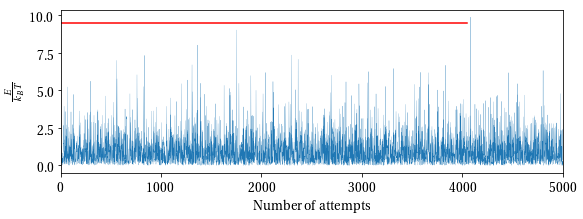

In [141]:
plt.rcParams['figure.figsize'] = [9, 3]
plt.plot(E, lw=0.2)
plt.axhline(9.5, 0, 0.81, c='r')
plt.xlim(0,5000)
plt.xlabel('Number of attempts')
plt.ylabel(r'$\frac{E}{k_B T}$')

In [142]:
np.log(2)/(3600*24)

8.022536812036404e-06

In [146]:
1e8/(3600*24*365)

3.170979198376459

In [151]:
np.exp(33)

214643579785916.06